

# 🕒 Hourly Energy Consumption Forecasting (PJM Dataset)

## Project Overview

In this project, we will work with the **PJM Hourly Energy Consumption Dataset**, a publicly available dataset from **Kaggle** that records **hourly electricity consumption** for the PJM Interconnection, a regional transmission organization (RTO) that coordinates electricity across multiple US states.

### 🔍 Use Case
Accurate **energy demand forecasting** is essential for:
- Balancing electricity supply and demand.
- Avoiding blackouts.
- Optimizing generation and distribution.
- Reducing operational costs.
- Supporting renewable energy integration.

We aim to build a **time series forecasting model** that predicts future energy demand based on historical hourly data.

---

## Steps to Follow in This Notebook

1. **Project Understanding and Setup**
2. **Data Loading and Preprocessing**
3. **Exploratory Data Analysis (EDA)**
4. **Modeling (Forecasting using SARIMA and Prophet)**
5. **Forecast Visualization and KPIs**
6. *(Next Step)* Streamlit Dashboard Integration for Interactive Visualization

---

In [ ]:
# =========================
# 📦 1. Importing Libraries
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")

## 📂 2. Data Loading and Understanding
We’ll use the **PJM Hourly Energy Consumption Dataset** from Kaggle.  
Each file represents a different region within the PJM network.  
We’ll begin with one region — for example, **PJM East** — and later this can be extended to other regions.  /content/PJME_hourly.csv

In [ ]:
# Load the dataset
url = "/content/PJME_hourly.csv"

df = pd.read_csv(url)

# Display basic info
print("Shape:", df.shape)
df.head()

Shape: (145366, 2)


,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
duplicate_count = df['Datetime'].duplicated().sum()
print(f"Number of duplicate timestamps: {duplicate_count}")

# Optionally display the duplicate timestamps
df[df['Datetime'].duplicated(keep=False)].head(10)

Number of duplicate timestamps: 4


,Datetime,PJME_MW
106584,2014-11-02 02:00:00,22935.0
106585,2014-11-02 02:00:00,23755.0
115368,2015-11-01 02:00:00,21567.0
115369,2015-11-01 02:00:00,21171.0
124008,2016-11-06 02:00:00,20795.0
124009,2016-11-06 02:00:00,21692.0
132816,2017-11-05 02:00:00,21236.0
132817,2017-11-05 02:00:00,20666.0


In [ ]:
# Convert datetime column
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Remove duplicate timestamps
df = df.drop_duplicates(subset='Datetime', keep='first')

# Set index and ensure hourly frequency
df = df.set_index('Datetime').asfreq('H')
df = df.sort_index()

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145392 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Freq: h
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145362 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


### Data Preprocessing
Before analysis, we:
- Check for **missing values**
- Handle them using **interpolation**
- Plot a quick line chart to visualize trends

PJME_MW    30
dtype: int64


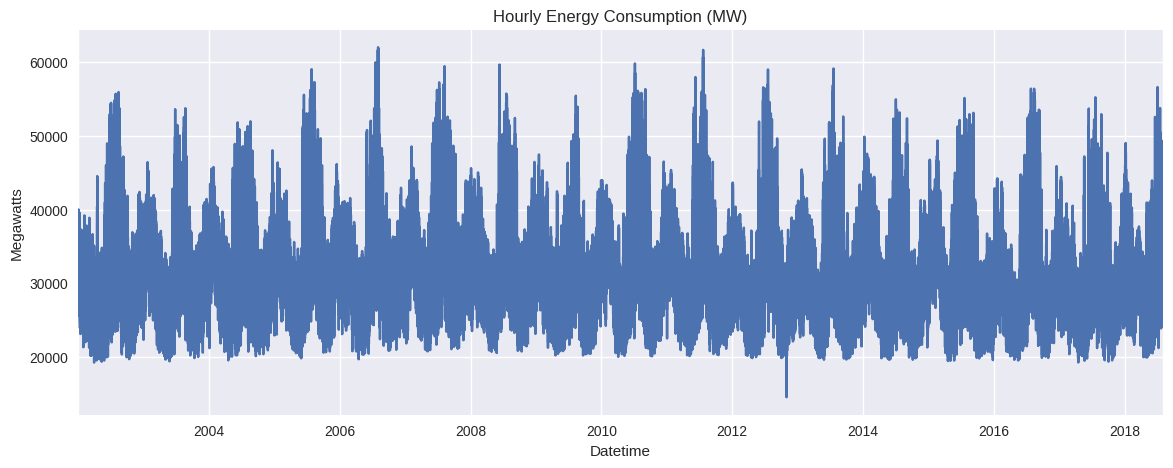

In [ ]:
# Check missing values
print(df.isna().sum())

# Interpolate missing MW values
df['PJME_MW'] = df['PJME_MW'].interpolate()

# Quick line plot
df['PJME_MW'].plot(figsize=(14,5), title='Hourly Energy Consumption (MW)')
plt.ylabel("Megawatts")
plt.show()

## 3. Exploratory Data Analysis (EDA)

We will perform EDA focusing on:
1. Overall consumption trends.
2. Daily, weekly, and monthly seasonality.
3. Hourly patterns (peak and off-peak hours).
4. Correlation and autocorrelation insights.

In [ ]:
# Add time-based columns
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year

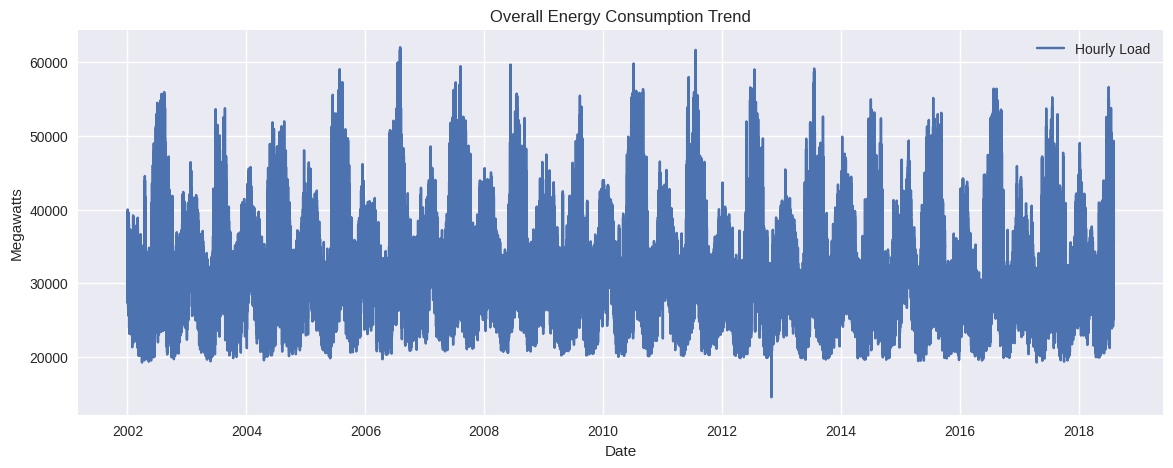

In [ ]:
## Trends Visualization

plt.figure(figsize=(14,5))
plt.plot(df['PJME_MW'], label='Hourly Load')
plt.title("Overall Energy Consumption Trend")
plt.xlabel("Date")
plt.ylabel("Megawatts")
plt.legend()
plt.show()

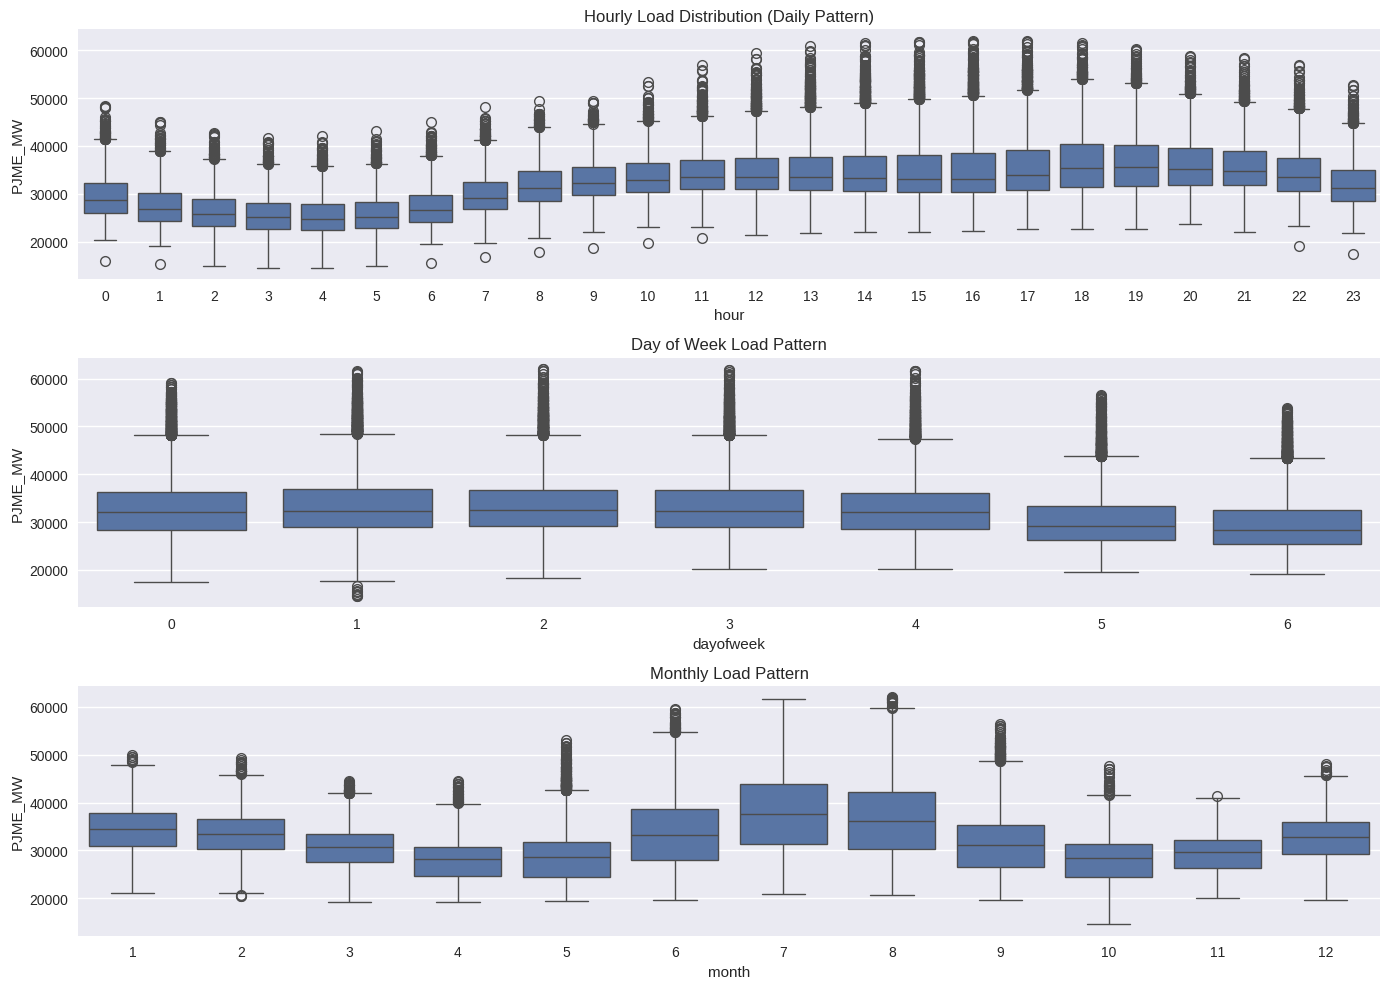

In [ ]:
## Seasonality Patterns

fig, axes = plt.subplots(3, 1, figsize=(14,10))
sns.boxplot(x='hour', y='PJME_MW', data=df, ax=axes[0])
axes[0].set_title("Hourly Load Distribution (Daily Pattern)")

sns.boxplot(x='dayofweek', y='PJME_MW', data=df, ax=axes[1])
axes[1].set_title("Day of Week Load Pattern")

sns.boxplot(x='month', y='PJME_MW', data=df, ax=axes[2])
axes[2].set_title("Monthly Load Pattern")
plt.tight_layout()
plt.show()

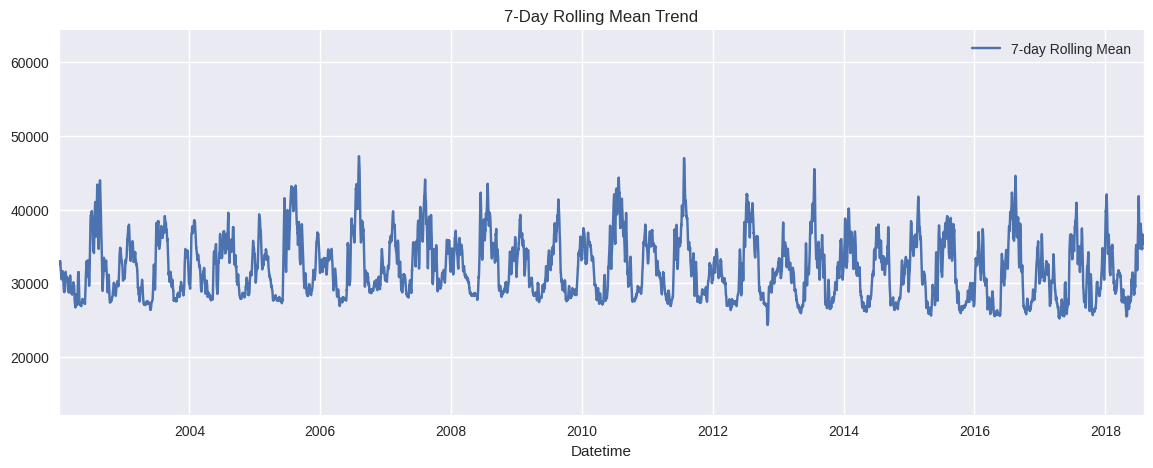

In [ ]:
## Rolling Statistics

plt.figure(figsize=(14,5))
df['PJME_MW'].rolling(window=24*7).mean().plot(label='7-day Rolling Mean')
plt.plot(df['PJME_MW'], alpha=0.3)
plt.title("7-Day Rolling Mean Trend")
plt.legend()
plt.show()

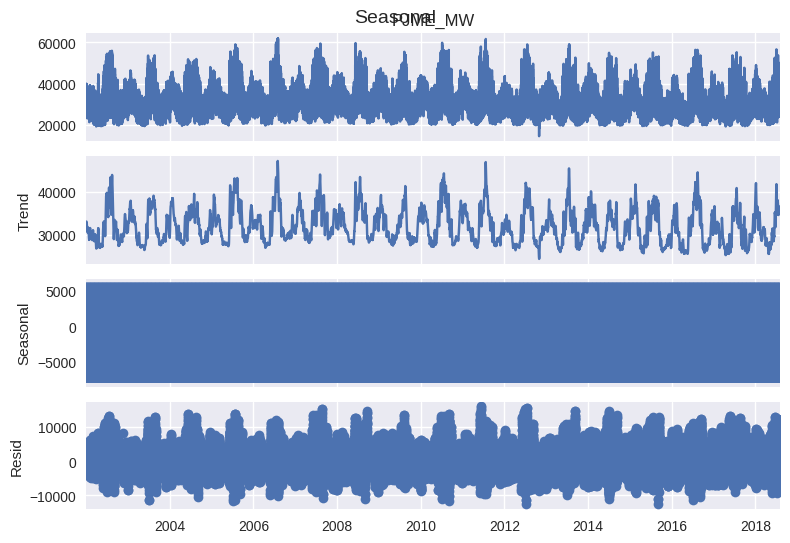

In [ ]:
## Seasonal Decomposition

decomposition = seasonal_decompose(df['PJME_MW'], model='additive', period=24*7)
decomposition.plot()
plt.suptitle("Seasonal", fontsize=14)
plt.show()

4. Forecasting Models

We’ll build two types of forecasting models:

1. **SARIMA (Seasonal ARIMA)** – classical statistical time series model.  
2. **Prophet** – Facebook’s model designed for strong seasonality and trend patterns.

In [ ]:
df_sample = df.last('180D')  # use last 180 days = 6 months
train = df_sample.iloc[:-24*7]
test = df_sample.iloc[-24*7:]

In [ ]:
## SARIMA

df_sample = df.last('180D')  # use last 180 days = 6 months

# Split data
train = df_sample.iloc[:-24*7]   # train on all but last week
test = df_sample.iloc[-24*7:]    # last 7 days for testing

# Fit SARIMA
sarima = SARIMAX(train['PJME_MW'], order=(1,1,1), seasonal_order=(1,1,1,24))
sarima_fit = sarima.fit(disp=False)

# Forecast
forecast = sarima_fit.forecast(steps=len(test))

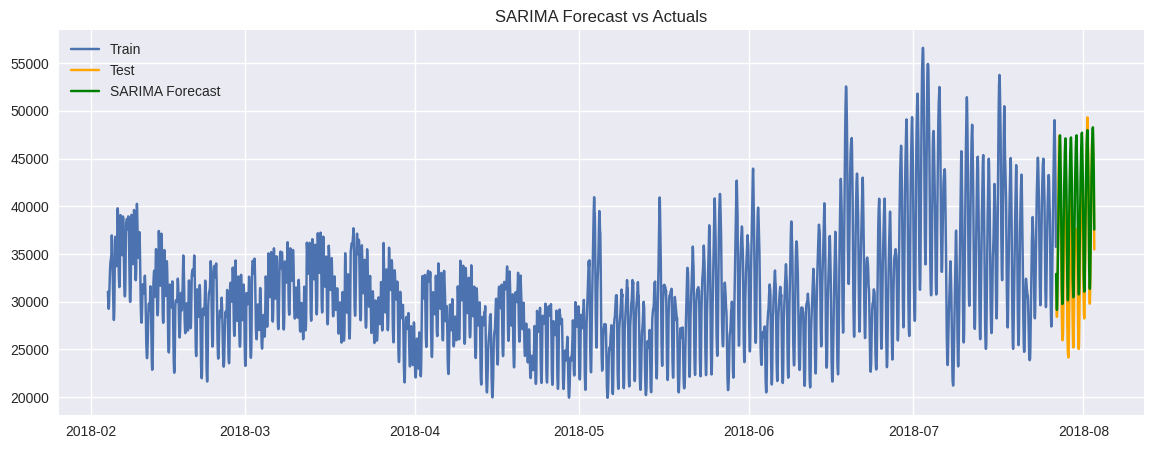

In [ ]:
## Plot SARIMa Results

plt.figure(figsize=(14,5))
plt.plot(train['PJME_MW'], label='Train')
plt.plot(test['PJME_MW'], label='Test', color='orange')
plt.plot(test.index, forecast, label='SARIMA Forecast', color='green')
plt.title("SARIMA Forecast vs Actuals")
plt.legend()
plt.show()

### Prophet Model Building

In [ ]:
## TODO: # Prepare data for Prophet
# Prepare data for Prophet
df_prophet = df.reset_index()[['Datetime', 'MW']]
df_prophet.columns = ['ds', 'y']

In [ ]:
# TODO: Fit Prophet

<details>
<summary>Click here for the answer</summary>

```python

m = Prophet(daily_seasonality=True, yearly_seasonality=True)
m.fit(df_prophet[:-24*7])
future = m.make_future_dataframe(periods=24*7, freq='H')
forecast_prophet = m.predict(future)

```
</details>

In [ ]:
# TODO: Plot Prophet Forecasts
m.plot(forecast_prophet)
plt.title("Prophet Forecast")
plt.show()

<details>
<summary>Click here for the answer</summary>

```python
# Example code
print("Hello, Shweta!")
```
</details>

## 📊 5. Evaluation & KPIs

We’ll compare actual vs predicted values using standard regression metrics:
- **MAE** – Mean Absolute Error  
- **RMSE** – Root Mean Squared Error

In [ ]:
# Compute metrics for SARIMA
mae = mean_absolute_error(test['PJME_MW'], forecast)
rmse = np.sqrt(mean_squared_error(test['PJME_MW'], forecast))

print(f" SARIMA Model Performance:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

 SARIMA Model Performance:
MAE:  3941.21
RMSE: 4757.97


## 6. Conclusions and Insights

- The energy load exhibits strong **daily and weekly seasonality**.
- **SARIMA** captures short-term patterns well but can be limited for long-term trends.
- **Prophet** provides flexible seasonality modeling and handles holiday effects easily (if added).
- Forecast accuracy can be further improved by:
  - Adding weather/temperature features.
  - Using LSTM or hybrid models.
  - Hyperparameter tuning and multi-region modeling.

---

## Next Step: Streamlit Dashboard

In the next part, we’ll convert this notebook into an **interactive Streamlit dashboard**, where:
- Users can select regions, date ranges, and models.
- View real-time plots and forecast KPIs.
- Compare model results interactively.


In [ ]:
# ============================================================
# 🧠 Time Series Analysis for Energy Forecasting
# 📊 Industrial Use Case: CNC Machine Energy Consumption
# ============================================================

# ------------------------------------------------------------
# 1. IMPORT LIBRARIES
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet
from google.colab import files
import io

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

print("✅ Libraries loaded successfully!")

## Data Upload

In [ ]:
# ------------------------------------------------------------
# 2. UPLOAD AND LOAD DATA
# ------------------------------------------------------------
data_url = "/content/DMC2_S_CP2.csv"

print("Loading dataset from URL...")
df = pd.read_csv(data_url)

print(f"Data loaded successfully from URL: {data_url}")
print(f"Shape of dataset: {df.shape[0]} rows × {df.shape[1]} columns\n")

# Preview first few rows
display(df.head())

## Dataset Descrption - as text

## Understand Data Structure

In [ ]:
# ------------------------------------------------------------
# 3. UNDERSTAND DATA STRUCTURE
# ------------------------------------------------------------
print("\n Basic Information about the dataset:")
df.info()

print("\n Checking for missing values:")
display(df.isnull().sum().sort_values(ascending=False).head(10))

print("\n Statistical summary of numeric columns:")
display(df.describe().T)

## Understand Data Features and Target Variable

In [ ]:
# ------------------------------------------------------------
# 4. FEATURE AND TARGET SELECTION
# ------------------------------------------------------------
print("\n Dataset Overview")
print("➡️ Total Columns in Dataset:", len(df.columns))
print("\n All Columns in the Dataset:")
print(list(df.columns))

# ------------------------------------------------------------
# Define Features and Targets explicitly
# ------------------------------------------------------------
features = [
    'LOAD|1', 'LOAD|2', 'LOAD|3', 'LOAD|6',
    'ENC_POS|1', 'ENC_POS|2', 'ENC_POS|3', 'ENC_POS|6',
    'CTRL_DIFF2|1', 'CTRL_DIFF2|2', 'CTRL_DIFF2|3', 'CTRL_DIFF2|6',
    'TORQUE|1', 'TORQUE|2', 'TORQUE|3', 'TORQUE|6',
    'DES_POS|1', 'DES_POS|2', 'DES_POS|3', 'DES_POS|6',
    'CTRL_DIFF|1', 'CTRL_DIFF|2', 'CTRL_DIFF|3', 'CTRL_DIFF|6',
    'CTRL_POS|1', 'CTRL_POS|2', 'CTRL_POS|3', 'CTRL_POS|6',
    'VEL_FFW|1', 'VEL_FFW|2', 'VEL_FFW|3', 'VEL_FFW|6',
    'CONT_DEV|1', 'CONT_DEV|2', 'CONT_DEV|3', 'CONT_DEV|6',
    'CMD_SPEED|1', 'CMD_SPEED|2', 'CMD_SPEED|3', 'CMD_SPEED|6',
    'TORQUE_FFW|1', 'TORQUE_FFW|2', 'TORQUE_FFW|3', 'TORQUE_FFW|6',
    'ENC1_POS|1', 'ENC1_POS|2', 'ENC1_POS|3', 'ENC1_POS|6',
    'ENC2_POS|1', 'ENC2_POS|2', 'ENC2_POS|3', 'ENC2_POS|6'
]

targets = ['CURRENT|1', 'CURRENT|2', 'CURRENT|3', 'CURRENT|6']

In [ ]:
print("\n Feature Columns :")
print(features)
print(f"Total Features Selected: {len(features)}")

print("\n Target Columns :")
print(targets)
print(f"Total Targets Selected: {len(targets)}")

# ------------------------------------------------------------
# Choose the main target variable for forecasting
# ------------------------------------------------------------
TARGET = 'CURRENT|6'
if TARGET not in df.columns:
    TARGET = targets[-1]  # fallback, just in case
print(f"\n Selected Target Variable for Forecasting: {TARGET}")

In [ ]:
# ------------------------------------------------------------
# Create Timestamp Column (if not present)
# ------------------------------------------------------------
if 'timestamp' not in df.columns:
    df['timestamp'] = pd.date_range(start='2024-01-01', periods=len(df), freq='S')

# ------------------------------------------------------------
# Create simplified DataFrame for analysis
# ------------------------------------------------------------
df_main = df[['timestamp', TARGET]].copy()
df_main.rename(columns={'timestamp': 'ds', TARGET: 'y'}, inplace=True)

# Handle missing values
#df_main['y'] = df_main['y'].interpolate(method='linear').fillna(method='bfill')

print("\n✅ Data prepared successfully for analysis!")
display(df_main.head())

## EDA

In [ ]:
# ------------------------------------------------------------
# 5. EXPLORATORY DATA ANALYSIS (EDA)
# ------------------------------------------------------------
print("\n Performing Exploratory Data Analysis (EDA)...")

# --- 5.1 Plot trend over time
plt.figure()
plt.plot(df_main['ds'], df_main['y'], color='steelblue')
plt.title(f"{TARGET} Trend over Time")
plt.xlabel("Time")
plt.ylabel(TARGET)
plt.show()

In [ ]:

# --- 5.2 Distribution of Target Variable
plt.figure()
sns.histplot(df_main['y'], bins=50, kde=True, color='teal')
plt.title(f"Distribution of {TARGET}")
plt.xlabel(TARGET)
plt.ylabel("Frequency")
plt.show()

In [ ]:
# --- 5.3 Boxplot to check for outliers
plt.figure()
sns.boxplot(x=df_main['y'], color='lightcoral')
plt.title(f"Outlier Detection in {TARGET}")
plt.show()

In [ ]:
# --- 5.4 Correlation Heatmap (features vs target)
print("\n Correlation Analysis (Top 10 features correlated with target):")
corr = df.corr(numeric_only=True)
if TARGET in corr.columns:
    top_corr = corr[TARGET].sort_values(ascending=False)[1:11]
    display(top_corr)

    plt.figure(figsize=(8, 4))
    sns.barplot(x=top_corr.values, y=top_corr.index, palette="viridis")
    plt.title(f"Top 10 Features Correlated with {TARGET}")
    plt.xlabel("Correlation Coefficient")
    plt.show()
else:
    print(" Skipping correlation plot — no numeric correlation matrix found.")

print(" EDA Completed Successfully!")

## Forecast Data

In [ ]:
# ------------------------------------------------------------
# 6. SIMPLE FORECASTING USING PROPHET
# ------------------------------------------------------------
print("\n🤖 Training Prophet forecasting model...")

model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
model.fit(df_main)

# Forecast for next 10000 seconds
future = model.make_future_dataframe(periods=10000, freq='S')
forecast = model.predict(future)

## Visualize Data

In [ ]:
# ------------------------------------------------------------
# 7. VISUALIZE FORECAST
# ------------------------------------------------------------
print("\n📊 Visualizing Forecast Results...")

fig1 = model.plot(forecast)
plt.title(f"Forecasting {TARGET} using Prophet")
plt.xlabel("Time")
plt.ylabel("Predicted Current|6 ")
plt.show()

fig2 = model.plot_components(forecast)
plt.show()


## Only Forcasted Part

In [ ]:
forecast_future = forecast[-10000:]  # Last 1000 predicted points
plt.figure(figsize=(10,4))
plt.plot(forecast_future['ds'], forecast_future['yhat'], label='Forecast', color='blue')
plt.fill_between(forecast_future['ds'],
                 forecast_future['yhat_lower'],
                 forecast_future['yhat_upper'],
                 color='skyblue', alpha=0.3)
plt.title("Forecasted Current|6 (Next 10000 Seconds)")
plt.xlabel("Time")
plt.ylabel("Predicted Current|6")
plt.legend()
plt.show()

## Evaluation

In [ ]:
# ------------------------------------------------------------
# 8. EVALUATION (Simple)
# ------------------------------------------------------------
print("\nEvaluating Model Performance...")

split_index = int(len(df_main) * 0.2)
actual = df_main['y'].iloc[split_index:]
predicted = forecast['yhat'].iloc[split_index:split_index + len(actual)]

mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
r2 = r2_score(actual, predicted)

print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

## Visualize Predictions

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(actual.index, actual.values, label='Actual', color='black')
plt.plot(predicted.index, predicted.values, label='Predicted', color='blue', alpha=0.7)
plt.title("Actual vs Predicted Current|6 (Test Set)")
plt.xlabel("Time")
plt.ylabel("Current|6")
plt.legend()
plt.show()

## Business Insights

In [ ]:
# ------------------------------------------------------------
# 9. BUSINESS INSIGHTS
# ------------------------------------------------------------
print("\n💡 Business Interpretation and Insights:")

threshold = df_main['y'].mean() + 1.5 * df_main['y'].std()
spike_pct = (forecast['yhat'] > threshold).mean() * 100

print(f"• The forecast shows about {spike_pct:.1f}% of upcoming operations may exceed the normal energy level.")
print("• Early detection of energy spikes helps reduce costs and schedule maintenance effectively.")
print("• Time series forecasting can make industrial systems more efficient, sustainable, and reliable.")

print("\n Workshop Complete: You’ve just built a simple industrial forecasting model!")